# 

In [1]:
pip install scikit-learn==1.5.0 imbalanced-learn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 63.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import json
import time
import torch
from collections import defaultdict, Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

from transformers import AutoTokenizer, AutoModel, TFAutoModel

from sentence_transformers import SentenceTransformer

import fasttext
import fasttext.util

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

2025-07-26 14:47:55.068292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753541275.235264      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753541275.283278      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
!gunzip cc.id.300.bin.gz

--2025-07-26 05:30:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.33, 3.171.22.118, 3.171.22.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4507049071 (4.2G) [application/octet-stream]
Saving to: ‘cc.id.300.bin.gz’

cc.id.300.bin.gz    100%[===================>]   4.20G   103MB/s    in 21s     

2025-07-26 05:30:21 (205 MB/s) - ‘cc.id.300.bin.gz’ saved [4507049071/4507049071]



In [3]:
df = pd.read_csv('/kaggle/input/newlaporgoiddata/RawDataBackup_6000.csv') 

In [4]:
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 samples:")
display(df.head())

Dataset shape: (6000, 14)

First 5 samples:


,meta-date,text-user,text-muted,text-muted 2,text-status,text-tracking,complaint-track-body,complaint-track-body href,complaint-title,complaint-title href,complaint-desc,text-muted 3,text-muted_3 href,meta-info
0,7 jam yang lalu,M Akbar,"Jumat, 13:53",Android - dinas-pekerjaan-umum-cipta-karya-dan...,Ditanggapi oleh Pelapor,NaN,Terdisposisi ke Dinas Pekerjaan Umum Cipta Kar...,https://www.lapor.go.id/instansi/dinas-pekerja...,Jalan Macan Putih Labanasem Bolong Dan Sangat ...,https://www.lapor.go.id/laporan/detil/jalan-ma...,Kepada yth dinas pekerjaan umum cipta karya pe...,JALAN BERLUBANG,https://www.lapor.go.id/laporan/kategori/jalan...,#9165816
1,7 jam yang lalu,M Akbar,"Jumat, 13:57",Android - dinas-pekerjaan-umum-cipta-karya-dan...,Ditanggapi oleh Pelapor,NaN,Terdisposisi ke Dinas Pekerjaan Umum Cipta Kar...,https://www.lapor.go.id/instansi/dinas-pekerja...,Jalan Dsn Sukopuro Rusak,https://www.lapor.go.id/laporan/detil/jalan-ds...,Kepada yth dinas pekerjaan umum cipta karya pe...,JALAN BERLUBANG,https://www.lapor.go.id/laporan/kategori/jalan...,#9165831
2,7 jam yang lalu,Hari Basir,"Selasa, 07:20",Website,Ditanggapi oleh Pelapor,NaN,Terdisposisi ke Kantor Pertanahan Kabupaten Og...,https://www.lapor.go.id/instansi/kantor-pertan...,"Laporan No. 8112829, 8588371 Dan 8630536 Baru ...",https://www.lapor.go.id/laporan/detil/laporan-...,Kepada yth. kementerian agraria dan tata ruang...,"SELASA, 2023/03/21",NaN,#9181051
3,7 jam yang lalu,Anonim,9 jam yang lalu,Website,Ditindaklanjuti oleh Instansi,Selesai otomatis dalam 10 hari,Terdisposisi ke Kantor Kesyahbandaran Dan Otor...,https://www.lapor.go.id/instansi/kantor-kesyah...,Jadwal Kapal,https://www.lapor.go.id/laporan/detil/jadwal-k...,Sebelumnya saya pernah melihat jadwal kapal di...,TRANSPORTASI LAUT,https://www.lapor.go.id/laporan/kategori/trans...,#9197446
4,7 jam yang lalu,Erie Koesbianto,"Kemarin, 02:19",Whatsapp,Ditindaklanjuti oleh Instansi,Selesai otomatis dalam 10 hari,Terdisposisi ke DINAS PU DAN TATA RUANG KABUPA...,https://www.lapor.go.id/instansi/dinas-pekerja...,Jalan Rusak,https://www.lapor.go.id/laporan/detil/jalan-ru...,Gus saya erie koesbianto dari ds banjar agung ...,JALAN BERLUBANG,https://www.lapor.go.id/laporan/kategori/jalan...,#9189446


In [5]:
# categories_flattened_full_capitalized.py

categories = {
    "AGAMA": ["HAJI DAN UMROH", "LAINNYA TERKAIT AGAMA", "PENDIDIKAN AGAMA", "PENYEDIAAN FASILITAS IBADAH"],
    "CORONA VIRUS": ["ALAT DAN LOGISTIK KESEHATAN", "ALAT RAPID TEST", "INFORMASI ALAT RAPID TEST", "KUALITAS ALAT RAPID TEST", "KUANTITAS ALAT RAPID TEST", "PERMOHONAN ALAT RAPID TEST", "PRODUKSI ALAT RAPID TEST", "APD", "KUALITAS APD", "KUANTITAS APD", "PENIMBUN APD", "PRODUKSI APD", "DISINFEKTAN, MASKER, DLL", "INFORMASI LOGISTIK KESEHATAN LAINNYA", "KUALITAS LOGISTIK KESEHATAN LAINNYA", "PENIMBUN LOGISTIK KESEHATAN", "PERMOHONAN LOGISTIK KESEHATAN", "PRODUKSI LOGISTIK KESEHATAN LAINNYA", "PCR KIT", "INFORMASI PCR KIT", "PENGADUAN PCR KIT", "PERMOHONAN PCR KIT", "VENTILATOR", "INFORMASI VENTILATOR", "KUALITAS VENTILATOR", "PERMOHONAN VENTILATOR", "PRODUKSI VENTILATOR", "BANTUAN MASYARAKAT CORONA", "BANSOS DAERAH (PEMPROV, KAB/KOTA)", "ADMIN BANSOS DAERAH COVID", "BESARAN BANSOS DAERAH COVID", "INFORMASI BANSOS DAERAH COVID", "KELUHAN BANSOSD AERAH COVID", "KEPESERTAAN BANSOS DAERAH COVID", "PENYELEWENGAN BANSOS DAERAH COVID", "BANSOS K/L", "ADMIN BANSOS KEMENDIKBUD", "BESARAN BANSOS KEMENDIKBUD", "INFORMASI BANSOS KEMENDIKBUD", "KELUHAN BANSOS KEMENDIKBUD", "KEPESERTAAN BANSOS KEMENDIKBUD", "PENYELEWENGAN BANSOS KEMENDIKBUD", "REALISASI BANSOS KEMENDIKBUD", "BANSOS PRESIDEN JABODETABEK", "BESARAN BANSOS PRESIDEN JABODETABEK", "INFORMASI BANSOS PRESIDEN JABODETABEK", "KELUHAN BANSOS PRESIDEN JABODETABEK", "KEPESERTAAN BANSOS PRESIDEN JABODETABEK", "PENYALURAN BANSOS PRESIDEN JABODETABEK", "BANTUAN LANGSUNG TUNAI DANA DESA (BLT DD)", "INFORMASI BLT DESA", "JUMLAHUANG BLT DESA", "KELUHAN BLT DESA", "PENERIMA BLT DESA", "TUNAI BLT DESA", "BANTUAN LISTRIK", "INFORMASI LISTRIK COVID", "KELUHAN LISTRIK COVID", "KEPESERTAAN LISTRIK COVID", "TEKNIS LISTRIK COVID", "BANTUAN SOSIAL TUNAI (BST)", "BESARAN BST COVID", "INFORMASI BST COVID", "KELUHAN BST COVID", "KEPESERTAAN BST COVID", "PENYALURAN BST COVID", "KARTU PRAKERJA", "APLIKASI PRA KERJA", "BIAYA KURSUS PRA KERJA", "INFORMASI PRA KERJA", "KELUHAN PRA KERJA", "KKN PRA KERJA", "KUOTA PRA KERJA", "MATERI PELATIHAN PRA KERJA", "PENDAFTARAN ONLINE PRA KERJA", "PENYALAHGUNAAN PRA KERJA", "SASARAN PRA KERJA", "TES PRA KERJA", "KERINGANAN KREDIT", "BIAYA KREDIT COVID", "INFORMASI KREDIT COVID", "KELUHAN KREDIT COVID", "PRAYARAT KREDIT COVID", "REALISASI KREDIT COVID", "REGULASI KREDIT COVID", "PKH PROGRAM KELUARGA HARAPAN", "BANSOS PKH", "DATA PKH", "FASILITAS PKH", "INFORMASI PKH", "KELUHAN PKH", "KKN PKH", "KKS PKH", "KOMPLEMENTARITAS PKH", "PERBANKAN PKH", "SDM PKH", "SOSIALISASI PKH", "PROGRAM KESELAMATAN POLRI", "INFORMASI PROGRAM KESELAMATAN", "KELUHAN PROGRAM KESELAMATAN", "PERBANKAN PROGRAM KESELAMATAN", "PROGRAM SEMBAKO", "DATA PROGRAM SEMBAKO", "E-WARONG", "INFORMASI PROGRAM SEMBAKO", "KELUHAN PROGRAM SEMBAKO", "KKS PROGRAM SEMBAKO", "PAKET PROGRAM SEMBAKO", "PENYALAHGUNAAN PROGRAM SEMBAKO", "PERBANKAN PROGRAM SEMBAKO", "SOSIALISASI PROGRAM SEMBAKO", "UMUM (SEMUA JPS COVID ATAU SKEMA BANSOS YANG LAIN)", "APRESIASI JPS COVID", "INFORMASI COVID-19", "LAINNYA", "INFORMASI MEDIA COVID-19 LAINNYA", "PENGADUAN HOTLINE/CALL CENTER 117", "INFORMASI CALL CENTER 117 COVID-19", "PENGADUAN CALL CENTER 117 COVID-19", "PENGADUAN HOTLINE/CALL CENTER 119", "INFORMASI CALL CENTER 119 COVID-19", "PENGADUAN CALL CENTER 119 COVID-19", "PENGADUAN MEDIA (CETAK DAN ELEKTRONIK) TENTANG COVID-19", "INFORMASI MEDIA ELEKTRONIK COVID-19", "PENGADUAN MEDIA COVID-19", "PENGADUAN WEBSITE TENTANG COVID-19", "PENGADUAN WEBSITE COVID-19", "PELAYANAN KESEHATAN", "PELAYANAN KESEHATAN IBU DAN ANAK", "PELAYANAN KESEHATAN LAIN YANG TERDAMPAK AKIBAT COVID-19", "PEMERIKSAAN PCR ATAU SWAB", "PEMULASARAN JENAZAH COVID-19", "RAPID TEST", "RUMAH SAKIT DARURAT COVID-19", "RUMAH SAKIT RUJUKAN", "STOCK OBAT", "TENAGA KESEHATAN ATAU INSTANSI KESEHATAN", "PERMINTAAN RUJUKAN PASIEN", "REALISASI RUJUKAN PASIEN", "PENDAMPINGAN KESEHATAN JIWA/MENTAL", "LAINNYA", "INFORMASI KESEHATAN JIWA", "ODGJ", "PENGADUAN LAYANAN KESEHATAN JIWA/MENTAL", "KUALITAS PELAYANAN KESEHATAN", "PERMOHONAN PENDAMPINGAN PSIKOLOG", "PERMOHONAN PENDAMPINGAN PSIKOLOG", "PENGADUAN KLAIM DAN VERIFIKASI PELAYANAN KESEHATAN PASIEN COVID-19", "BIAYA PERAWATAN PASIEN COVID-19", "PEMBAYARAN COVID-19", "PEMBAYARAN COVID-19 LAINNYA", "INFORMASI", "INFORMASI KLAIM COVID-19", "KRITERIA PASIEN YANG DITANGGUNG DALAM SKEMA COVID", "KRITERIA PASIEN", "LAINNYA", "INFORMASI BPJS COVID LAINNYA", "PENGAJUAN KLAIM PELAYANAN KESEHATAN COVID-19", "PENGADUAN KLAIM COVID-19", "PROSES VERIFIKASI DATA PASIEN COVID-19", "VERIFIKASI KLAIM COVID-19", "PSBB", "BEKERJA DARI RUMAH (WFH)", "WFH", "BELAJAR DARI RUMAH", "BELAJAR DARI RUMAH PT", "DIKDASMEN DARI RUMAH", "JAGA JARAK AMAN (SOCIAL DISTANCING)", "PELANGGARAN SOCIAL DISTANCING", "SOCIAL DISTANCING", "KARANTINA WILAYAH", "ASPIRASI KARANTINA WILAYAH", "KEBIJAKAN NASIONAL KARANTINA WILAYAH"],
    "EKONOMI DAN KEUANGAN": ["ANGGARAN DAN PERBENDAHARAAN", "BEA DAN CUKAI", "KAWASAN EKONOMI KHUSUS", "KEKAYAAN NEGARA DAN LELANG", "KEPUASAN KONSUMEN", "KOPERASI, USAHA KECIL, DAN MENENGAH", "LAINNYA TERKAIT EKONOMI DAN KEUANGAN", "PENANAMAN MODAL/ INVESTASI", "PERBANKAN", "JASA KEUANGAN", "INDUSTRI KEUANGAN NON-BANK", "DANA PENSIUN", "LAINNYA TERKAIT INDUSTRI KEUANGAN NON-BANK", "LEMBAGA JASA KEUANGAN KHUSUS", "LEMBAGA KEUANGAN MIKRO", "LEMBAGA PEMBIAYAAN", "PERASURANSIAN", "LAINNYA TERKAIT JASA KEUANGAN", "PASAR MODAL", "PERBANKAN", "LAYANAN KEUANGAN DIGITAL/FINTECH", "BUNGA FINTECH", "E-METERAI", "INFORMASI LEGALITAS FINTECH", "LAINNYA TERKAIT LAYANAN KEUANGAN DIGITAL/FINTECH", "SISTEM PENAGIHAN FINTECH", "PAJAK", "AMNESTI PAJAK", "LAINNYA TERKAIT PAJAK", "PAJAK BADAN", "PAJAK DAERAH", "PAJAK PERORANGAN", "RETRIBUSI PAJAK", "PARIWISATA", "DESTINASI PARIWISATA", "KEBUDAYAAN", "LAINNYA TERKAIT PARIWISATA", "PENGADAAN BARANG/JASA", "ADVOKASI HUKUM PEMERINTAH DAERAH", "PENANGANAN SENGKETA/PERMASALAHAN HUKUM/PENYIMPANGAN TENDER", "SDM PBJ", "JABATAN FUNGSIONAL PENGELOLA PBJ", "SERTIFIKASI PBJ", "SISTEM PENGADAAN BARANG/JASA PEMERINTAH", "SISTEM INFORMASI KINERJA PENYEDIA (SIKAP)", "SISTEM RENCANA UMUM PENGADAAN (SIRUP)", "PENGIRIMAN BARANG/ LOGISTIK", "LAINNYA TERKAIT PENGIRIMAN BARANG/ LOGISTIK", "LAYANAN POS", "PENGIRIMAN LUAR NEGERI", "PERDAGANGAN", "INTRADE/ PERIZINANAN PERDAGANGAN", "KETERSEDIAAN BARANG KEBUTUHAN POKOK", "LAINNYA TERKAIT PERDAGANGAN", "PEMANTAUAN HARGA BAHAN POKOK", "PERIMBANGAN KEUANGAN PUSAT DAN DAERAH", "APBD", "BUMD", "LAINNYA TERKAIT PERIMBANGAN KEUANGAN PUSAT DAN DAERAH", "PERINDUSTRIAN", "HOME INDUSTRI", "LAINNYA TERKAIT PERINDUSTRIAN", "PERIZINAN HOME INDUSTRI"],
    "KESEHATAN": ["BANTUAN BIAYA PENDIDIKAN", "AFIRMASI DOKTER/DOKTER GIGI", "DOKTER LAYANAN PRIMER", "DOKTER SPESIALIS FELLOWSHIP", "DOKTER SUB-SPESIALIS/SPESIALIS DAN DOKTER GIGI SUB-SPESIALIS/SPESIALIS", "SDM KESEHATAN", "GIZI BURUK/STUNTING", "LAINNYA TERKAIT KESEHATAN", "PELAYANAN OBAT", "TENAGA MEDIS/ STR", "JAMINAN SOSIAL KESEHATAN", "ADMINISTRASI BPJS KESEHATAN", "ALAMAT DOMISILI PESERTA TIDAK SESUAI", "ALUR PELAYANAN TIDAK JELAS", "ANAK 21 TAHUN PPU YG MASIH KULIAH", "ANTRIAN LAMA", "APLIKASI PENDAFTARAN MACET", "APLIKASI PENDAFTARAN SULIT DI AKSES", "APLIKASI PENDAFTARAN TIDAK USERFRIENDLY", "CARA MENGGUNAKAN APLIKASI PENDAFTARAN", "DAFTAR ISIAN PESERTA SULIT DIPAHAMI", "DATA DI ENTRY TIDAK SESUAI", "DENDA SUDAH DI BAYARKAN NAMUN TIDAK DAPAT CETAK SEP", "FASKES TK. I PESERTA TIDAK SESUAI", "FORMULIR PENDAFTARAN TIDAK TERSEDIA", "FRONTLINER TIDAK RAMAH", "HAK KELAS RAWAT PESERTA TIDAK SESUAI", "HAK PESERTA", "HOTLINE SEVICE/KANTOR CABANG/RO SULIT DIHUBUNGI", "IDENTITAS ALAMAT DOMISILI/SURAT MENYURAT", "IDENTITAS JENIS KELAMIN", "IDENTITAS NAMA", "IDENTITAS NOMOR HANDPHONE/TELPON/E-MAIL", "IDENTITAS TANGGAL LAHIR", "INFORMASI DARI PETUGAS TIDAK JELAS", "INFORMASI SULIT DI PEROLEH", "INFORMASI TIDAK JELAS", "INFORMASI TIDAK SESUAI", "JADWAL TIDAK JELAS", "JARINGAN OFFLINE", "JUMLAH DENDA PELAYANAN TIDAK SESUAI", "KANAL PENDAFTARAN (LOKASI, HARI/JAM PELAYANAN)", "KANAL PIPP", "KANAL PIPP TIDAK DAPAT DI AKSES", "KARTU IDENTITAS PESERTA", "KARTU TIDAK DITERIMA LEBIH DARI 6 HARI KERJA SETELAH PEMBAYARAN IURAN PERTAMA", "KELUHAN PBPU", "KELUHAN PPU", "KENDALA PINDAH SEGMEN KARENA TUNGGAKAN IURAN", "KEWAJIBAN PESERTA", "LAINNYA TERKAIT ADMINISTRASI BPJS KESEHATAN", "LAPORAN KETIDAKPATUHAN BADAN USAHA DALAM MEMBERIKAN DATA YANG BENAR (KEBENARAN DATA)", "LOKASI KC/KK SULIT DITEMUKAN", "MANFAAT PENJAMINAN", "NAMA PESERTA TIDAK SESUAI", "NIK PESERTA TIDAK SESUAI", "NO HP / EMAIL TIDAK SESUAI", "NON-AKTIF ANAK PPU USIA > 21 TAHUN", "NON-AKTIF KARENA DATA GANDA", "NON-AKTIF KARENA IURAN", "NON-AKTIF KARENA MENINGGAL", "NON-AKTIF KARENA TIDAK MASUK SK MENSOS", "NON-AKTIF KARENA USIA DIATAS 90 TAHUN", "NON-AKTIF PENANGGUHAN PESERTA", "NON-AKTIF SETELAH PERPINDAHAN SEGMEN", "PELAYANAN LAMBAT", "PENAMBAHAN ANGGOTA KELUARGA", "PENANGANAN TIDAK SOLUTIF", "PENDAFTARAN BAYI BARU LAHIR", "PENGAKTIFAN PESERTA DIATAS 90 TAHUN", "PENOLAKAN PESERTA DARI LUAR DAERAH DI FKTP", "PENONAKTIFAN PESERTA MENINGGAL DUNIA", "PERMINTAAN INFORMASI TENTANG PENDAFTARAN PBI", "PERMINTAAN INFORMASI TENTANG PENDAFTARAN PPU PNS", "PERUBAHAN FASILITAS KESEHATAN TINGKAT I", "PERUBAHAN KELAS RAWAT", "PERUBAHAN SEGMEN KEPESERTAAN", "PETUGAS TIDAK RAMAH", "PROSEDUR PENDAFTARAN", "PROSEDUR PENGGANTIAN KARTU", "PROSES PENDAFTARAN LAMA/ TIDAK SESUAI SLA", "SARANA DAN PRASARANA TIDAK MEMADAI", "SATPAM TIDAK RAMAH", "SLA PENANGANAN PENGADUAN", "SOSIALISASI KURANG", "SOSIALISASI TERLAMBAT", "SOSIALISASI TIDAK JELAS", "STATUS KEPESERTAAN", "SUSUNAN ANGGOTA KELUARGA TIDAK SESUAI KK", "SYARAT PENDAFTARAN", "TANGGAL LAHIR / JENIS KELAMIN PESERTA TIDAK SESUAI", "WAKTU PENANGANAN PENGADUAN LAMA", "IURAN DAN DENDA BPJS KESEHATAN", "AUTODEBET PEMBAYARAN PERTAMA GAGAL TIDAK TERINFORMASIKAN", "BANK TIDAK BERSEDIA MELAKUKAN REGISTRASI AUTODEBET", "BESARAN IURAN", "CEK TAGIHAN/PEMBAYARAN", "GAGAL REGISTRASI AUTODEBET TIDAK TERINFORMASIKAN", "HASIL REKONSILIASI IURAN TIDAK SESUAI DENGAN TAGIHAN", "IURAN TIDAK SESUAI", "IURAN TIDAK TERSPLIT KE ANGGOTA KELUARGA LAIN", "LAINNYA TERKAIT IURAN DAN DENDA BPJS KESEHATAN", "LAMANYA PROSES REFUND", "LOKASI PEMBAYARAN IURAN", "NOMOR VA TIDAK DIKENAL", "NOMOR VIRTUAL ACCOUNT", "PEMBAYARAN IURAN BAYI BARU LAHIR", "PROSEDUR REFUND", "PROSES AUTODEBET GAGAL", "REKONSILIASI/PENYESUAIAN TAGIHAN", "SYARAT DAN PROSEDUR AUTODEBET", "TAGIHAN IURAN TIDAK MUNCUL SETELAH 14 HARI PENDAFTARAN", "TATA CARA PEMBAYARAN IURAN", "LAINNYA TERKAIT JAMINAN SOSIAL KESEHATAN", "MASALAH JAMINAN SOSIAL", "ASURANSI KESEHATAN", "ASURANSI KETENAGAKERJAAN", "ASURANSI PROFESI", "PELAYANAN KESEHATAN BPJS", "ADANYA MANFAAT PELAYANAN YANG SEHARUSNYA DIJAMIN NAMUN MENJADI TANGGUNGAN PESERTA", "AKSES FASILITAS KESEHATAN SULIT", "ALAMAT DAN JAM PELAYANAN FASILITAS KESEHATAN", "ALAT BANTU KESEHATAN KOSONG", "AMBULANCE TIDAK TERSEDIA DI FKTP", "ANTRIAN MENDAPATKAN PELAYANAN", "DOKTER DI FKTP KURANG MEMAHAMI PROGRAM RUJUK BALIK", "DOKTER DI RS TIDAK MEMBERIKAN SURAT RUJUK BALIK", "FASILITAS KESEHATAN KURANG MEMAHAMI PROGRAM PROMOTIF PREVENTIF", "FASILITAS KESEHATAN TIDAK MENJALANKAN PROGRAM PROMOTIF PREVENTIF", "GANGGUAN APLIKASI EDABU", "GANGGUAN APLIKASI P-CARE", "HAK KELAS PERAWATAN", "IUR BIAYA ALAT BANTU KESEHATAN TIDAK SESUAI KETENTUAN", "IUR BIAYA NAIK KELAS TIDAK SESUAI KETENTUAN", "IUR BIAYA PELAYANAN AMBULANCE", "IUR BIAYA PELAYANAN FKRTL YANG TIDAK SESUAI", "IUR BIAYA PELAYANAN FKTP YANG TIDAK SESUAI", "JADWAL PRAKTEK TIDAK SESUAI", "KAMAR HANYA TERSEDIA UNTUK PASIEN UMUM/PEMBEDAAN PASIEN", "KAMAR PENUH", "KARTU PESERTA DISALAH GUNAKAN", "KEKOSONGAN RUANG PERAWATAN KHUSUS (ICCU, ICU, NICU, HCU, PICU DLL.)", "KETENTUAN DAN PROSEDUR PEMBAYARAN DENDA PELAYANAN", "KIS DIGITAL TIDAK DITERIMA DI FASKES", "KURANGNYA INFORMASI TENTANG KETERSEDIAAN TEMPAT TIDUR", "LAINNYA TERKAIT PELAYANAN KESEHATAN BPJS", "LAMANYA ANTRIAN PENDAFTARAN DI FASILITAS KESEHATAN", "LAMANYA ANTRIAN UNTUK MENDAPATKAN TINDAKAN MEDIS/PELAYANAN KESEHATAN", "LINGKUP MANFAAT PELAYANAN YANG DI TANGGUNG", "PASIEN DI ARAHKAN UNTUK NAIK KELAS TANPA PENJELASAN", "PELAYANAN ALAT BANTU KESEHATAN", "PELAYANAN AMBULAN", "PELAYANAN DENGAN COB", "PELAYANAN DI LUAR WILAYAH DOMISILI", "PELAYANAN GAWAT DARURAT", "PELAYANAN GAWAT DARURAT TIDAK DILAYANI DI RUMAH SAKIT YANG BELUM BEKERJA SAMA", "PELAYANAN KESEHATAN YANG TIDAK DITANGGUNG", "PENJAMINAN PESERTA DI HARI LIBUR", "PENOLAKAN PERSALINAN NORMAL DI FKRTL", "PERMINTAAN INFORMASI TENTANG AKOMADASI ATAU KETERSEDIAAN RUANG RAWAT INAP", "PESERTA DI RAWAT DIKELAS YG TIDAK SESUAI HAKNYA", "PESERTA DI TOLAK FASILITAS KESEHATAN DILUAR WILAYAH DOMISILI", "PETUGAS ADMINISTRASI TIDAK RAMAH", "PETUGAS MEDIS DAN PARAMEDIS TIDAK RAMAH", "POLI RUMAH SAKIT TUJUAN RUJUKAN TUTUP/TIDAK UPDATE", "PROGRAM COB TIDAK BERJALAN SEBAGAIMANA MESTINYA", "PROGRAM PROMOTIF PREVENTIF", "PROGRAM RUJUK BALIK", "PROSEDUR PELAYANAN KESEHATAN", "RUMAH SAKIT TUJUAN RUJUKAN PENUH", "RUMAH SAKIT TUJUAN RUJUKAN TERLALU JAUH", "SISTEM RUJUKAN BERJENJANG/RUJUKAN ONLINE", "TIDAK DIBERIKAN PELAYANAN AMBULANCE", "TIDAK DILAYANI KARENA TIDAK TERMASUK KATEGORI GAWAT DARURAT", "PELAYANAN OBAT BPJS KESEHATAN", "ASPIRASI", "JUMLAH OBAT RUJUK BALIK YANG DIBERIKAN TIDAK SESUAI DENGAN YANG DI RESEPKAN", "KEKOSONGAN OBAT", "LAINNYA TERKAIT PELAYANAN OBAT BPJS KESEHATAN", "OBAT RUJUK BALIK KOSONG", "MASALAH DISIPLIN PROFESI", "KEPEMILIKAN SERTIFIKAT KOMPETENSI", "KEPEMILIKAN SIP", "KEPEMILIKAN STR", "KEPEMILIKAN SURAT TUGAS", "PENDAFTARAN SIP BARU", "PERMOHONAN SIP (SURAT IZIN PRAKTEK)", "MASALAH KESEJAHTERAAN", "CUTI TIDAK DIBERIKAN/TIDAK SESUAI KETENTUAN", "GAJI/UPAH DIBAYARKAN TIDAK TEPAT WAKTU", "GAJI/UPAH TIDAK DIBAYARKAN", "IMBALAN JASA PELAYANAN/MEDIS DIBAYARKAN TIDAK TEPAT WAKTU", "IMBALAN JASA PELAYANAN/MEDIS TIDAK DIBAYARKAN", "PENGHARGAAN TIDAK DIBERIKAN", "THR DIBAYARKAN TIDAK TEPAT WAKTU", "THR TIDAK DIBAYARKAN", "TIDAK SESUAI KESEPAKATAN", "TUNJANGAN KINERJA/INSENTIF/TAMBAHAN PENGHASILAN PEGAWAI (TPP) DIBAYARKAN TIDAK TEPAT WAKTU", "TUNJANGAN KINERJA/INSENTIF/TAMBAHAN PENGHASILAN PEGAWAI (TPP) TIDAK DIBAYARKAN", "MASALAH PENEMPATAN/PENUGASAN", "KEBUTUHAN TENAGA MEDIS DAN TENAGA KESEHATAN DI RUMAH SAKIT SUDAH TERPENUHI", "PEMERINTAH DAERAH TIDAK MENDUKUNG PENEMPATAN/PENUGASAN TENAGA MEDIS DAN TENAGA KESEHATAN", "RUMAH SAKIT TIDAK MEMILIKI INSENTIF", "RUMAH SAKIT TIDAK MEMILIKI SARANA DAN PRASARANA", "RUMAH SAKIT TIDAK MENYEDIAKAN RUMAH DINAS, KENDARAAN DINAS, DLL", "MASALAH PERLINDUNGAN HUKUM", "FASILITASI PERLINDUNGAN HUKUM", "KEKERASAN DAN PELECEHAN DI LINGKUNGAN KERJA", "PELAYANAN KESEHATAN", "FASILITAS KESEHATAN", "FOGGING NYAMUK", "KERAMAHAN PETUGAS KESEHATAN", "LAINNYA TERKAIT PELAYANAN KESEHATAN", "LAYANAN AMBULAN", "MALPRAKTIK KESEHATAN", "MASALAH PELAYANAN KESEHATAN", "PELAYANAN KESEHATAN TIDAK SESUAI DENGAN STANDAR PROFESI, STANDAR PELAYANAN, STANDAR PROSEDUR OPERASIONAL, ETIKA PROFESI, DAN KEBUTUHAN PASIEN", "PELAYANAN VAKSINASI / IMUNISASI", "VAKSINASI RABIES", "PENDAYAGUNAAN TENAGA MEDIS DAN TENAGA KESEHATAN", "INTERNSHIP", "PENDAYAGUNAAN DOKTER SPESIALIS (PDGS)", "PENDAYAGUNAAN PASCA PENERIMA BANTUAN PENDIDIKAN", "PENUGASAN KHUSUS INDIVIDU DAN PENUGASAN KHUSUS TIM", "TENAGA MEDIS DAN TENAGA KESEHATAN WNA LULUSAN DALAM NEGERI", "TENAGA MEDIS DAN TENAGA KESEHATAN WNA LULUSAN LUAR NEGERI", "PERIZINAN DAN PENGAWASAN LAYANAN KESEHATAN", "LAINNYA TERKAIT PERIZINAN DAN PENGAWASAN LAYANAN KESEHATAN", "PENCABUT IZIN APOTEK", "PENGAWASAN OBAT DAN MAKANAN", "PENGAWASAN RUMAH SAKIT", "PERIZINAN DAN PENGAWASAN APOTEK", "PERIZINAN DAN PENGAWASAN KLINIK"],
    "KESETARAAN GENDER DAN SOSIAL INKLUSIF": ["AKSES MASYARAKAT BERKEBUTUHAN KHUSUS/ DISABILITAS", "ANAK TERLANTAR", "EKSPLOITASI ANAK", "KEKERASAN DALAM RUMAH TANGGA", "KESETARAAN GENDER", "LAINNYA TERKAIT KESETARAAN GENDER DAN SOSIAL INKLUSIF", "PELECEHAN SEKSUAL"],
    "KETENTERAMAN, KETERTIBAN UMUM, DAN PELINDUNGAN MASYARAKAT": ["KEPOLISIAN", "KERESAHAN MASYARAKAT", "SAMPAH LIAR", "KRIMINALITAS", "PENYELUNDUPAN SATWA", "PERDAGANGAN ORANG", "LAINNYA TERKAIT KEPOLISIAN", "NOMOR KENDARAAN", "SURAT IZIN MENGEMUDI", "SURAT KETERANGAN CATATAN KEPOLISIAN", "SURAT TANDA NOMOR KENDARA", "KETERTIBAN UMUM", "TAWURAN/ RUSUH", "LAINNYA TERKAIT KETENTERAMAN, KETERTIBAN UMUM, DAN PELINDUNGAN MASYARAKAT", "PEMADAMAN KEBAKARAN", "RADIKALISME", "SARA"],
    "LINGKUNGAN HIDUP DAN KEHUTANAN": ["KEHUTANAN", "EKSPLOITASI HUTAN", "HUTAN ADAT", "HUTAN KEMASYARAKATAN", "HUTAN TANAMAN RAKYAT", "KEBAKARAN HUTAN", "KEMITRAAN KEHUTANAN", "LAHAN GAMBUT", "LAINNYA TERKAIT KEHUTANAN", "LEGALISASI HUTAN", "REDISTRIBUSI HUTAN", "KELAUTAN DAN PERIKANAN", "ILEGAL FISHING", "KAPAL LAUT ASING", "LAINNYA TERKAIT KELAUTAN DAN PERIKANAN", "LAINNYA TERKAIT LINGKUNGAN HIDUP DAN KEHUTANAN", "REDD+", "BIOCF", "FCPF-CF", "PENANGGULANGAN BENCANA", "BANJIR", "GEMPA BUMI", "LAINNYA TERKAIT PENANGGULANGAN BENCANA", "LONGSOR", "PENCEMARAN LINGKUNGAN", "PENEBANGAN LIAR (ILEGAL LOGGING)", "PENGELOLAAN SAMPAH", "PERLINDUNGAN FLORA", "PERLINDUNGAN SATWA", "REDD+", "SANITASI"],
    "PEKERJAAN UMUM DAN PENATAAN RUANG": ["BENDUNGAN", "DRAINASE (GORONG-GORONG/PARIT)", "LAINNYA TERKAIT PEKERJAAN UMUM DAN PENATAAN RUANG", "PASAR", "PERMUKIMAN", "INFRASTRUKTUR JALAN", "JALAN BERLUBANG", "JEMBATAN", "LAINNYA TERKAIT INFRASTRUKTUR JALAN", "LAINNYA TERKAIT INFRASTRUKTUR JALAN", "PENERANGAN JALAN", "INFRASTRUKTUR PENDUKUNG", "HALTE", "JEMBATAN PENYEBERANGAN ORANG (JPO)", "LAINNYA TERKAIT INFRASTRUKTUR PENDUKUNG", "LAPANGAN OLAHRAGA", "TAMAN", "TEMPAT PEMAKAMAN UMUM", "TROTOAR", "PERTANAHAN", "LAINNYA TERKAIT PERTANAHAN", "SENGKETA TANAH", "SERTIFIKAT TANAH", "PERUMAHAN BERSUBSIDI DAN RUMAH SUSUN", "SUBSIDI BANTUAN UANG MUKA", "SUMBER DAYA AIR", "REKOMTEK SUMBER DAYA AIR"],
    "PEMBANGUNAN DESA, DAERAH TERTINGGAL, DAN TRANSMIGRASI": ["LAINNYA TERKAIT PEMBANGUNAN DESA, DAERAH TERTINGGAL, DAN TRANSMIGRASI", "TRANSMIGRASI", "PEMBANGUNAN DESA DAN DAERAH TERTINGGAL", "BADAN USAHA MILIK DESA", "LAINNYA TERKAIT PEMBANGUNAN DESA DAN DAERAH TERTINGGAL", "PEMERINTAHAN DESA", "DANA DESA", "ALOKASI DANA DESA", "BLT (BANTUAN LANGSUNG TUNAI) DANA DESA", "LAINNYA TERKAIT DANA DESA", "PENYALAHGUNAAN DANA DESA"],
    "PENDIDIKAN DAN KEBUDAYAAN": ["BALAI DIKLAT", "KARTU INDONESIA PINTAR/KIP", "KEBUDAYAAN", "LAINNYA TERKAIT PENDIDIKAN DAN KEBUDAYAAN", "PAUD DAN PENDIDIKAN INFORMAL", "POLITEKNIK", "PENDIDIKAN DASAR DAN MENENGAH", "ADMINISTRASI SISWA", "BIAYA SEKOLAH", "LAINNYA TERKAIT PENDIDIKAN DASAR DAN MENENGAH", "NISN (NOMOR INDUK SISWA) NASIONAL", "NPSN (NOMOR POKOK SEKOLAH NASIONAL)", "PENERIMAAN SISWA BARU", "PROGRAM SEKOLAH PENGGERAK", "PENDIDIKAN TINGGI", "BEASISWA", "DATA MAHASISWA", "LAINNYA TERKAIT PENDIDIKAN TINGGI", "NIDN (NOMOR INDUK DOSEN NASIONAL)/DOSEN", "PENERIMAAN MAHASISWA BARU", "PENYETARAAN IJAZAH", "PROGRAM KAMPUS MERDEKA", "VOKASI"],
    "PERTANIAN DAN PETERNAKAN": ["BANTUAN PERTANIAN", "BIBIT PERTANIAN", "GABUNGAN KELOMPOK TANI", "IRIGASI PERTANIAN", "LAINNYA TERKAIT PERTANIAN DAN PETERNAKAN", "PENANGGULANGAN BENCANA PERTANIAN", "PENGEMBANGAN SARANA PERTANIAN", "PETERNAKAN", "PUPUK"],
    "POLITIK DAN HUKUM": ["ADMINISTRASI HUKUM UMUM (AHU) ONLINE", "ADMINISTRASI HUKUM UMUM (AHU) ONLINE", "FIDUSIA", "KEWARGANEGARAAN", "KOPERASI", "LAINNYA TERKAIT ADMINISTRASI HUKUM UMUM (AHU) ONLINE", "LEGALISASI", "MLA (MUTUAL LEGAL ASSISTANCE)", "NOTARIS", "PARPOL", "PERKUMPULAN", "PERSEROAN PERORANGAN", "PERSEROAN TERBATAS", "PEWARGANEGARAAN", "WASIAT", "YAYASAN", "BPHN", "DANA BANTUAN HUKUM", "JDIH (JARINGAN DATA INFORMASI HUKUM)", "PENYULUHAN HUKUM", "HAK ASASI MANUSIA (HAM)", "PELAYANAN KOMUNIKASI MASYARAKAT", "PERMASALAHAN HAM", "HUKUM", "LAINNYA TERKAIT HUKUM", "LEMBAGA PEMASYARAKATAN", "PERLINDUNGAN WNI/WNA", "IMIGRASI", "AFFIDAVIT", "ALIH STATUS TINGGAL", "KARTU IZIN TINGGAL TERBATAS (KITAS)", "KARTU IZIN TINGGAL TETAP (KITAP)", "LAINNYA TERKAIT IMIGRASI", "PASPOR", "PELAPORAN ORANG ASING", "PENGURUSAN KEWARGANEGARAAN", "VISA", "KEKAYAAN INTELEKTUAL", "DESAIN INDUSTRI", "DTLST (DESAIN TATA LETAK SIRKUIT TERPADU)", "HAK CIPTA", "INDIKASI GEOGRAFIS", "LAINNYA TERKAIT KEKAYAAN INTELEKTUAL", "MEREK", "PATEN", "RAHASIA DAGANG", "KEWASPADAAN NASIONAL", "LAINNYA TERKAIT POLITIK DAN HUKUM", "PEMILIHAN KEPALA DESA/PILKADES", "KORUPSI, KOLUSI, DAN NEPOTISME", "LAINNYA TERKAIT KORUPSI, KOLUSI, DAN NEPOTISME", "PENYALAHGUNAAN WEWENANG", "PUNGUTAN LIAR", "PEMILIHAN UMUM", "DAFTAR PEMILIH TETAP PEMILU", "LAINNYA TERKAIT PEMILIHAN UMUM", "PELANGGARAN ADMINISTRASI PEMILU", "PENGADILAN NEGERI DAN PENGADILAN AGAMA", "ADMINISTRASI PERADILAN", "PERKARA GUGATAN", "PERKARA PERMOHOAN", "PERKARA VOLUNTER", "LAINNYA TERKAIT PENGADILAN NEGERI DAN PENGADILAN AGAMA", "PERATURAN PERUNDANG-UNDANGAN", "HARMONISASI", "LITERASI PERATURAN PERUNDANG-UNDANGAN", "PERATURAN KEMENTERIAN", "RANCANGAN PERATURAN PERUNDANG-UNDANGAN", "PERMASYARAKATAN", "CUTI BERSYARAT", "CUTI MENJELANG BEBAS", "LAINNYA TERKAIT PERMASYARAKATAN", "PELAYANAN TAHANAN/NAPI", "PEMBEBASAN BERSYARAT", "PENDAFTARAN KUNJUNGAN", "PENGUSULAN ASIMILASI"],
    "POLITISASI ASN": ["AJAKAN DAN HIMBAUAN KEPADA ASN UNTUK KEPENTINGAN POLITIK", "LAINNYA TERKAIT POLITISASI ASN", "PELAKSANAAN PERTEMUAN ASN UNTUK KEPENTINGAN POLITIK", "PEMANFAATAN FASILITAS NEGARA UNTUK KEPENTINGAN POLITIK", "PEMANFAATAN JABATAN UNTUK KEPENTINGAN POLITIK", "PEMBERIAN BARANG KEPADA ASN UNTUK KEPENTINGAN POLITIK"],
    "SOSIAL DAN KESEJAHTERAAN": ["BANTUAN SOSIAL", "BANSOS DAERAH", "BANTUAN PANGAN NON TUNAN (BPNT)", "BANTUAN SOSIAL TUNAI (BST)", "BLSM (BANTUAN LANGSUNG SEMENTARA MASYARAKAT)", "DATA TERPADU KESEJAHTERAAN SOSIAL (DTKS)", "KARTU INDONEISA SEHAT (KIS)", "KARTU INDONESIA PINTAR (KIP)", "KARTU KELUARGA SEJAHTERA (KKS)", "KARTU PERLINDUNGAN SOSIAL (KPS)", "KOMPENSASI LAINNYA", "LAINNYA TERKAIT BANTUAN SOSIAL", "PKH PROGRAM KELUARGA HARAPAN", "RUMAH SEJAHTERA TERPADU (RST)", "SUBSIDI LISTRIK", "LAINNYA TERKAIT SOSIAL DAN KESEJAHTERAAN", "KEJELASAN TPP ASN", "PANGAN", "PEMBERDAYAAN MASYARAKAT"],
    "SP4N-LAPOR!": ["GANGGUAN APLIKASI SP4N-LAPOR!", "KRITIK DAN SARAN UNTUK SP4N-LAPOR!", "PENGEMBANGAN SP4N-LAPOR!", "PENGHAPUSAN AKUN SP4N-LAPOR!", "PENGHAPUSAN LAPORAN SP4N-LAPOR!"],
    "ENERGI DAN SUMBER DAYA ALAM": ["LAINNYA TERKAIT ENERGI DAN SUMBER DAYA ALAM", "LAYANAN AIR MINUM", "BIAYA/TARIF PDAM", "GANGGUAN LAYANAN PENYALURAN AIR", "LAINNYA TERKAIT LAYANAN AIR MINUM", "LISTRIK", "INFORMASI KELISTRIKAN", "LAINNYA TERKAIT LISTRIK", "LAYANAN KELISTRIKAN", "PEMADAMAN LISTRIK", "PEMASANGAN LISTRIK BARU", "SARANA/PRASARANA KELISTRIKAN", "TARIF LISTRIK", "MIGAS", "GAS BERSUBSIDI", "HARGA MINYAK DAN GAS", "KELANGKAAN BBM/ELPIJI", "LAINNYA TERKAIT MIGAS", "PENDISTRIBUSIAN BBM DAN GAS", "PENYALURAN MINYAK DAN GAS", "PERTAMBANGAN", "DAMPAK LINGKUNGAN AREA PERTAMBANGAN", "IZIN PERTAMBANGAN", "KECELAKAAN PERTAMBANGAN", "LAHAN PERTAMBANGAN", "LAINNYA TERKAIT PERTAMBANGAN"],
    "EVAKUASI HEWAN LIAR": [],
    "FASILITAS DIPLOMATIK": [],
    "KEKERASAN DI SATUAN PENDIDIKAN (SEKOLAH, KAMPUS, LEMBAGA KURSUS)": ["GABUNGAN ATAU LAINNYA", "INTOLERANSI DAN KEKERASAN SEKSUAL", "KEKERASAN SEKSUAL, PERUNDUNGAN, DAN INTOLERANSI", "LAINNYA", "PERUNDUNGAN DAN INTOLERANSI", "PERUNDUNGAN DAN KEKERASAN SEKSUAL", "INTOLERANSI", "KEKERASAN SEKSUAL", "PERUNDUNGAN (BULLYING)"],
    "KEPENDUDUKAN": ["ADMINISTRASI KEPENDUDUKAN DAN PENCATATAN SIPIL", "AKTA KELAHIRAN", "AKTA KEMATIAN", "KARTU IDENTITAS ANAK", "KARTU KELUARGA", "KTP (KARTU TANDA PENDUDUK)", "LAINNYA TERKAIT ADMINISTRASI KEPENDUDUKAN DAN PENCATATAN SIPIL", "PINDAH DOMISILI", "SINKRONISASI DATA KEPENDUDUKAN", "SURAT KETERANGAN TEMPAT TINGGAL / DOMISILI", "ADMINISTRASI KEWILAYAHAN", "BATAS WILAYAH KAB/KOTA/PROVINSI", "LAINNYA TERKAIT ADMINISTRASI KEWILAYAHAN", "LAINNYA TERKAIT KEPENDUDUKAN", "SENSUS PENDUDUK", "PENGENDALIAN PENDUDUK DAN KELUARGA BERENCANA", "LAINNYA TERKAIT PENGENDALIAN PENDUDUK DAN KELUARGA BERENCANA", "PENYULUHAN KB", "PERNIKAHAN", "AKTA PERCERAIAN", "AKTA PERKAWINAN", "LAINNYA TERKAIT PERNIKAHAN", "SURAT PERMOHONAN NUMPANG NIKAH"],
    "KERJASAMA BILATERAL": [],
    "KERJASAMA MULTILATERAL": [],
    "KETENAGAKERJAAN": ["HAK PEKERJA", "CUTI", "GAJI PEKERJA", "LAINNYA TERKAIT HAK PEKERJA", "PENSIUN", "JAMINAN SOSIAL KETENAGAKERJAAN", "BPJS-TK MOBILE", "DUPLIKASI SERTIFIKAT", "INFO NOMOR KARTU", "INFORMASI E-KLAIM", "INFORMASI E-SALDO", "INFORMASI PENCAIRAN", "INFORMASI SMS SALDO", "IURAN JAMINAN PENSIUN", "JAMINAN HARI TUA", "JAMINAN KECELAKAAN KERJA", "JAMINAN KEMATIAN", "JAMINAN PENSIUN", "KONFIRMASI DATA KPJ (KARTU PESERTA JAMSOSTEK)", "LAINNYA TERKAIT JAMINAN SOSIAL KETENAGAKERJAAN", "LAYANAN KANTOR CABANG", "OPERASIONAL KANTOR", "PENDAFTARAN CABANG PERUSAHAAN", "PENDAFTARAN TENAGA KERJA ASING", "PENDAFTARAN VIA WEBSITE", "PERHITUNGAN IURAN", "PERMINTAAN KONSULTASI", "PROGRAM BPU (BUKAN PENERIMA UPAH)", "PROGRAM EPS (ELEKTRONIK PAY SYSTEM)", "PROGRAM JASA KONSTRUKSI", "PROGRAM KPR (KREDIT PEMILIKAN RUMAH) BPJS TK", "SIPP (SISTEM INFORMASI PELAPORAN PERUSAHAAN) ONLINE", "STATUS KEPESERTAAN", "STATUS KLAIM", "KEPEGAWAIAN", "CPNS", "GAJI DAN TUKIN", "KEBIJAKAN ASN", "LAINNYA TERKAIT KEPEGAWAIAN", "MUTASI PEGAWAI", "PANGKAT, JABATAN, DAN KINERJA ASN", "PEMBINAAN KEPEGAWAIAN", "PENSIUN ASN", "SERTIFIKASI DOSEN", "SK KEPEGAWAIAN", "TENAGA HONORER", "PENDIDIK DAN TENAGA KEPENDIDIKAN", "GURU DAN TENAGA KEPENDIDIKAN (GTK)", "TUNJANGAN PROFESI GURU", "LAINNYA TERKAIT PENDIDIK DAN TENAGA KEPENDIDIKAN", "NOMOR INDUK DOSEN NASIONAL (NIDN)", "NOMOR UNIK PENDIDIK DAN TENAGA KEPENDIDIKAN (NUPTK)", "KESELAMATAN PEKERJA", "LAINNYA TERKAIT KETENAGAKERJAAN", "REKRUTMEN TENAGAKERJA", "TENAGA KERJA ASING (TKA)", "ADMINISTRASI DAN IZIN TKA (TENAGA KERJA ASING)", "LAINNYA TERKAIT TENAGA KERJA ASING (TKA)", "PEMBINAAN TKA (TENAGA KERJA ASING)", "PERLINDUNGAN TKA (TENAGA KERJA ASING)", "TENAGA KERJA INDONESIA/ PEKERJA MIGRAN INDONESIA (TKI/MI)", "ADMINISTRASI TKI (TENAGA KERJA INDONESIA)", "LAINNYA TERKAIT ADMINISTRASI TKI (TENAGA KERJA INDONESIA)", "PENEMPATAN PEKERJA MIGRAN INDONESIA (PMI)", "SURAT IZIN PENGERAHAN PEKERJA MIGRAN INDONESIA (PMI)", "LAINNYA TERKAIT TENAGA KERJA INDONESIA/ PEKERJA MIGRAN INDONESIA (TKI/MI)", "PELAYANAN INFORMASI PASAR KERJA LUAR NEGERI", "PEMBINAAN PERUSAHAAN PENEMPATAN PEKERJA MIGRAN INDONESIA (P3MI)", "PERLINDUNGAN PEKERJA MIGRAN INDONESIA (PMI)", "LAINNYA TERKAIT PERLINDUNGAN PEKERJA MIGRAN INDONESIA (PMI)", "PENYELESAIAN KASUS PEKERJA MIGRAN INDONESIA (PMI)", "PERLINDUNGAN INDIVIDU PEKERJA MIGRAN INDONESIA (PMI)", "PERLINDUNGAN KELUARGA PEKERJA MIGRAN INDONESIA (PMI)"],
    "LEGALISASI KONSULER": [],
    "NETRALITAS ASN": ["ASN KAMPANYE POLITIK DI MEDIA SOSIAL", "ASN TURUT SERTA DALAM KAMPANYE OFFLINE", "FOTO BERSAMA PESERTA PEMILU", "IKUT SERTA DALAM KEGIATAN POLITIK", "LAINNYA TERKAIT NETRALITAS ASN", "PENGGUNAAN ATRIBUT PESERTA PEMILU", "PROVOKASI ATAS PESERTA PEMILU TERTENTU"],
    "PELINDUNGAN WNI": [],
    "PEMULIHAN EKONOMI NASIONAL": ["INTENSIF USAHA", "KESEHATAN", "PERLINDUNGAN SOSIAL", "SEKTORAL DAN PEMDA", "UMKM"],
    "PENCEGAHAN DAN PEMBERANTASAN PENYALAHGUNAAN DAN PEREDARAN GELAP NARKOTIKA DAN PREKURSOR NARKOTIKA (P4GN)": ["PENYALAHGUNAAN NARKOTIKA", "TRANSAKSI NARKOTIKA"],
    "PENIADAAN MUDIK": ["PELANGGARAN MUDIK ASN", "PELANGGARAN MUDIK NON ASN"],
    "PERAIRAN": ["DUGAAN PUNGUTAN LIAR DI PERAIRAN / ILLEGAL CHARGES (MARINE)"],
    "PERHUBUNGAN": ["LAINNYA TERKAIT PERHUBUNGAN", "LAMPU PENERANGAN JALAN UMUM", "PARKIR LIAR", "TRANSPORTASI DARAT", "TRANSPORTASI LAUT", "TRANSPORTASI ONLINE", "PERKERETAAPIAN", "APLIKASI KAI ACCESS", "JADWAL KEBERANGKATAN", "LAINNYA TERKAIT PERKERETAAPIAN", "SARANA DAN PRASARANA KAI", "LAYANAN KERETA API", "LAINNYA TERKAIT LAYANAN KERETA API", "LAYANAN PETUGAS GERBONG", "LAYANAN PETUGAS STASIUN", "LAYANAN TIKET", "TRANSPORTASI UDARA", "JADWAL KEBERANGKATAN", "LAINNYA TERKAIT TRANSPORTASI UDARA", "LAYANAN MASKAPAI", "TARIF PENERBANGAN"],
    "PERLINDUNGAN KONSUMEN": ["PERLINDUNGAN KONSUMEN TERKAIT BARANG ELEKTRONIK, TELEMATIKA, DAN KENDARAAN BERMOTOR", "PERLINDUNGAN KONSUMEN TERKAIT JASA KEUANGAN", "PERLINDUNGAN KONSUMEN TERKAIT JASA LAYANAN KESEHATAN", "PERLINDUNGAN KONSUMEN TERKAIT JASA LOGISTIK", "PERLINDUNGAN KONSUMEN TERKAIT JASA PARIWISATA", "PERLINDUNGAN KONSUMEN TERKAIT JASA TELEKOMUNIKASI", "PERLINDUNGAN KONSUMEN TERKAIT JASA TRANSPORTASI", "PERLINDUNGAN KONSUMEN TERKAIT LISTRIK DAN GAS RUMAH TANGGA", "PERLINDUNGAN KONSUMEN TERKAIT OBAT DAN MAKANAN", "PERLINDUNGAN KONSUMEN TERKAIT PERUMAHAN", "PERLINDUNGAN KONSUMEN TERKAIT TRANSAKSI PERDAGANGAN MELALUI SISTEM ELEKTRONIK (E-COMMERCE)"],
    "PROGRAM MAKAN BERGIZI GRATIS (MBG)": ["DISTRIBUSI & PENYALURAN MBG", "KEMITRAAN MBG", "KOORDINASI DAN SOSIALISASI MBG", "KUALITAS MAKANAN MBG", "PELAKSANAAN MBG DI SEKOLAH", "PENGAWASAN DAN EVALUASI"],
    "SELEKSI CALON HAKIM AGUNG RI": [],
    "SRGI": [],
    "TEKNOLOGI INFORMASI DAN KOMUNIKASI": ["BLOKIR NOMOR TELEPON", "CSIRT", "JARINGAN INTERNET", "KRIPTOGRAFI", "TANDA TANGAN ELEKTRONIK/E-SIGN", "BLOKIR WEBSITE", "KONTEN PENIPUAN", "KONTEN PORNOGRAFI", "LAIINYA TERKAIT BLOKIR WEBSITE", "PERJUDIAN ONLINE", "PHISING/ PENGELABUHAN", "INFORMASI TERKAIT APLIKASI PEMERINTAH", "SIOLA KEMENDAGRI", "LAINNYA TERKAIT TEKNOLOGI INFORMASI DAN KOMUNIKASI", "BEASISWA S2/S3 BIDANG KOMINFO", "DIGITAL TALENT SCHOLARSHIP", "JARINGAN INTERNET", "TIANG JARINGAN INTERNET", "LAYANAN ONLINE/APLIKASI PEMERINTAH", "APLIKASI JAMINAN SOSIAL", "APLIKASI KEPENDUDUKAN", "APLIKASI KEUANGAN", "LAIINYA TERKAIT LAYANAN ONLINE/APLIKASI PEMERINTAH", "SIPD KEMENDAGRI", "APLIKASI PERIZINAN", "SIMBG", "WEBSITE BADAN PUSAT STATISTIK", "KONSULTASI DATA"],
    "TOPIK KHUSUS": ["BANSOS DIGITAL 2021", "JENIS, MUTU, DAN HARGA BAHAN PANGAN", "KEPESERTAAN", "MEKANISME PENYALURAN", "MERCHANT YANG BEKERJA SAMA", "PENYALAHGUNAAN BANTUAN", "PROGRAM", "SALDO", "SOSIALISASI DAN EDUKASI", "SUBSIDI LISTRIK", "SUBSIDI LPG"],
    "TOPIK LAINNYA": [],
}


In [6]:
sub_to_main = defaultdict(str)
for main_cat, subcats in categories.items():
    for subcat in subcats:
        sub_to_main[subcat] = main_cat

def categorize_text(text):
    if pd.isna(text) or not str(text).strip():
        return None, None
    
    text_upper = str(text).strip().upper()
    
    # Case 1: Exact match with a main category
    if text_upper in categories:
        return text_upper, text_upper
    
    # Case 2: Exact match with a subcategory
    if text_upper in sub_to_main:
        return sub_to_main[text_upper], text_upper
    
    # Case 3: Partial match with subcategories
    for subcat, main_cat in sub_to_main.items():
        if subcat in text_upper:  # Check if subcategory string appears in the text
            return main_cat, subcat
    
    return None, None

def categorize_dataframe(df, text_column='text-muted 3'):
    # Apply categorization
    df[['main_category', 'sub_category']] = df[text_column].apply(lambda x: pd.Series(categorize_text(x)))
    
    # Count stats
    total = len(df)
    non_empty = df[text_column].notna().sum()
    matched = df['main_category'].notna().sum()
    
    print(f"Total rows: {total}")
    print(f"Non-empty '{text_column}': {non_empty}")
    print(f"Successfully categorized: {matched} ({matched/non_empty:.1%})")
    print(f"Uncategorized: {non_empty - matched}")
    
    return df

In [7]:
df = categorize_dataframe(df)

df.to_csv('categorized_output.csv', index=False, sep='\t')

uncategorized = df[df['text-muted 3'].notna() & df['main_category'].isna()]
if len(uncategorized) > 0:
    print("\nTop 20 uncategorized texts:")
    print(uncategorized['text-muted 3'].value_counts().head(20))

Total rows: 6000
Non-empty 'text-muted 3': 3784
Successfully categorized: 3278 (86.6%)
Uncategorized: 506

Top 20 uncategorized texts:
text-muted 3
SENIN, 2025/07/14           26
KAMIS, 2025/07/10           21
SENIN, 2025/07/07           19
SELASA, 2025/07/15          17
SOSIAL DAN KESEJAHTERAAN    17
SELASA, 2025/07/08          16
JUMAT, 2025/07/11           15
SELASA, 2025/07/01          15
RABU, 2025/07/09            15
KAMIS, 2025/06/19           13
KAMIS, 2025/07/17           12
MINGGU, 2025/07/06          12
SENIN, 2025/06/30           11
RABU, 2025/07/16            11
KAMIS, 2025/07/03           11
RABU, 2025/07/02            11
JUMAT, 2025/07/04            9
MINGGU, 2025/07/13           8
SABTU, 2025/07/05            7
JUMAT, 2025/07/18            6
Name: count, dtype: int64


In [8]:
categorized_df = df[df['main_category'].notna()].copy()

print(f"Original dataset: {len(df):,} rows")
print(f"After filtering: {len(categorized_df):,} rows")
print(f"Removed {len(df) - len(categorized_df):,} uncategorized rows")

categorized_df.reset_index(drop=True, inplace=True)

categorized_df.to_csv('categorized_data_filtered.csv', index=False, sep='\t')

print("\nSample of categorized data:")
print(categorized_df[['text-muted 3', 'main_category', 'sub_category']].head())

Original dataset: 6,000 rows
After filtering: 3,278 rows
Removed 2,722 uncategorized rows

Sample of categorized data:
                          text-muted 3                      main_category  \
0                      JALAN BERLUBANG  PEKERJAAN UMUM DAN PENATAAN RUANG   
1                      JALAN BERLUBANG  PEKERJAAN UMUM DAN PENATAAN RUANG   
2                    TRANSPORTASI LAUT                        PERHUBUNGAN   
3                      JALAN BERLUBANG  PEKERJAAN UMUM DAN PENATAAN RUANG   
4  KOPERASI, USAHA KECIL, DAN MENENGAH               EKONOMI DAN KEUANGAN   

                          sub_category  
0                      JALAN BERLUBANG  
1                      JALAN BERLUBANG  
2                    TRANSPORTASI LAUT  
3                      JALAN BERLUBANG  
4  KOPERASI, USAHA KECIL, DAN MENENGAH  


In [9]:
display(categorized_df.head())

,meta-date,text-user,text-muted,text-muted 2,text-status,text-tracking,complaint-track-body,complaint-track-body href,complaint-title,complaint-title href,complaint-desc,text-muted 3,text-muted_3 href,meta-info,main_category,sub_category
0,7 jam yang lalu,M Akbar,"Jumat, 13:53",Android - dinas-pekerjaan-umum-cipta-karya-dan...,Ditanggapi oleh Pelapor,NaN,Terdisposisi ke Dinas Pekerjaan Umum Cipta Kar...,https://www.lapor.go.id/instansi/dinas-pekerja...,Jalan Macan Putih Labanasem Bolong Dan Sangat ...,https://www.lapor.go.id/laporan/detil/jalan-ma...,Kepada yth dinas pekerjaan umum cipta karya pe...,JALAN BERLUBANG,https://www.lapor.go.id/laporan/kategori/jalan...,#9165816,PEKERJAAN UMUM DAN PENATAAN RUANG,JALAN BERLUBANG
1,7 jam yang lalu,M Akbar,"Jumat, 13:57",Android - dinas-pekerjaan-umum-cipta-karya-dan...,Ditanggapi oleh Pelapor,NaN,Terdisposisi ke Dinas Pekerjaan Umum Cipta Kar...,https://www.lapor.go.id/instansi/dinas-pekerja...,Jalan Dsn Sukopuro Rusak,https://www.lapor.go.id/laporan/detil/jalan-ds...,Kepada yth dinas pekerjaan umum cipta karya pe...,JALAN BERLUBANG,https://www.lapor.go.id/laporan/kategori/jalan...,#9165831,PEKERJAAN UMUM DAN PENATAAN RUANG,JALAN BERLUBANG
2,7 jam yang lalu,Anonim,9 jam yang lalu,Website,Ditindaklanjuti oleh Instansi,Selesai otomatis dalam 10 hari,Terdisposisi ke Kantor Kesyahbandaran Dan Otor...,https://www.lapor.go.id/instansi/kantor-kesyah...,Jadwal Kapal,https://www.lapor.go.id/laporan/detil/jadwal-k...,Sebelumnya saya pernah melihat jadwal kapal di...,TRANSPORTASI LAUT,https://www.lapor.go.id/laporan/kategori/trans...,#9197446,PERHUBUNGAN,TRANSPORTASI LAUT
3,7 jam yang lalu,Erie Koesbianto,"Kemarin, 02:19",Whatsapp,Ditindaklanjuti oleh Instansi,Selesai otomatis dalam 10 hari,Terdisposisi ke DINAS PU DAN TATA RUANG KABUPA...,https://www.lapor.go.id/instansi/dinas-pekerja...,Jalan Rusak,https://www.lapor.go.id/laporan/detil/jalan-ru...,Gus saya erie koesbianto dari ds banjar agung ...,JALAN BERLUBANG,https://www.lapor.go.id/laporan/kategori/jalan...,#9189446,PEKERJAAN UMUM DAN PENATAAN RUANG,JALAN BERLUBANG
4,7 jam yang lalu,Anonim,"Kemarin, 00:56",Website,Ditindaklanjuti oleh Instansi,NaN,Terdisposisi ke Deputi Bidang Usaha Mikro,https://www.lapor.go.id/instansi/deputi-usaha-...,Kur Umkm,https://www.lapor.go.id/laporan/detil/kur-umkm...,"Siang pak saya anak dari alm suhardi batubara,...","KOPERASI, USAHA KECIL, DAN MENENGAH",https://www.lapor.go.id/laporan/kategori/koper...,#9188891,EKONOMI DAN KEUANGAN,"KOPERASI, USAHA KECIL, DAN MENENGAH"


In [10]:
columns_to_drop = [
    'meta-date',           
    'text-user', 
    'text-muted',
    'text-muted 2',
    'text-tracking',
    'complaint-track-body href',
    'complaint-title href',
    'text-muted 3',
    'text-muted_3 href',	
    'text-status'
]

categorized_df = categorized_df.drop(columns=columns_to_drop)

In [11]:
display(categorized_df.head())
print(f"{len(categorized_df):,} rows")

,complaint-track-body,complaint-title,complaint-desc,meta-info,main_category,sub_category
0,Terdisposisi ke Dinas Pekerjaan Umum Cipta Kar...,Jalan Macan Putih Labanasem Bolong Dan Sangat ...,Kepada yth dinas pekerjaan umum cipta karya pe...,#9165816,PEKERJAAN UMUM DAN PENATAAN RUANG,JALAN BERLUBANG
1,Terdisposisi ke Dinas Pekerjaan Umum Cipta Kar...,Jalan Dsn Sukopuro Rusak,Kepada yth dinas pekerjaan umum cipta karya pe...,#9165831,PEKERJAAN UMUM DAN PENATAAN RUANG,JALAN BERLUBANG
2,Terdisposisi ke Kantor Kesyahbandaran Dan Otor...,Jadwal Kapal,Sebelumnya saya pernah melihat jadwal kapal di...,#9197446,PERHUBUNGAN,TRANSPORTASI LAUT
3,Terdisposisi ke DINAS PU DAN TATA RUANG KABUPA...,Jalan Rusak,Gus saya erie koesbianto dari ds banjar agung ...,#9189446,PEKERJAAN UMUM DAN PENATAAN RUANG,JALAN BERLUBANG
4,Terdisposisi ke Deputi Bidang Usaha Mikro,Kur Umkm,"Siang pak saya anak dari alm suhardi batubara,...",#9188891,EKONOMI DAN KEUANGAN,"KOPERASI, USAHA KECIL, DAN MENENGAH"


3,278 rows


Counts by Main Category:
main_category
TOPIK LAINNYA                                                                                               746
PEKERJAAN UMUM DAN PENATAAN RUANG                                                                           546
KETENAGAKERJAAN                                                                                             262
SOSIAL DAN KESEJAHTERAAN                                                                                    212
PENDIDIKAN DAN KEBUDAYAAN                                                                                   203
KETENTERAMAN, KETERTIBAN UMUM, DAN PELINDUNGAN MASYARAKAT                                                   194
PERHUBUNGAN                                                                                                 175
LINGKUNGAN HIDUP DAN KEHUTANAN                                                                              161
TEKNOLOGI INFORMASI DAN KOMUNIKASI                               

/tmp/ipykernel_36/1791911979.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


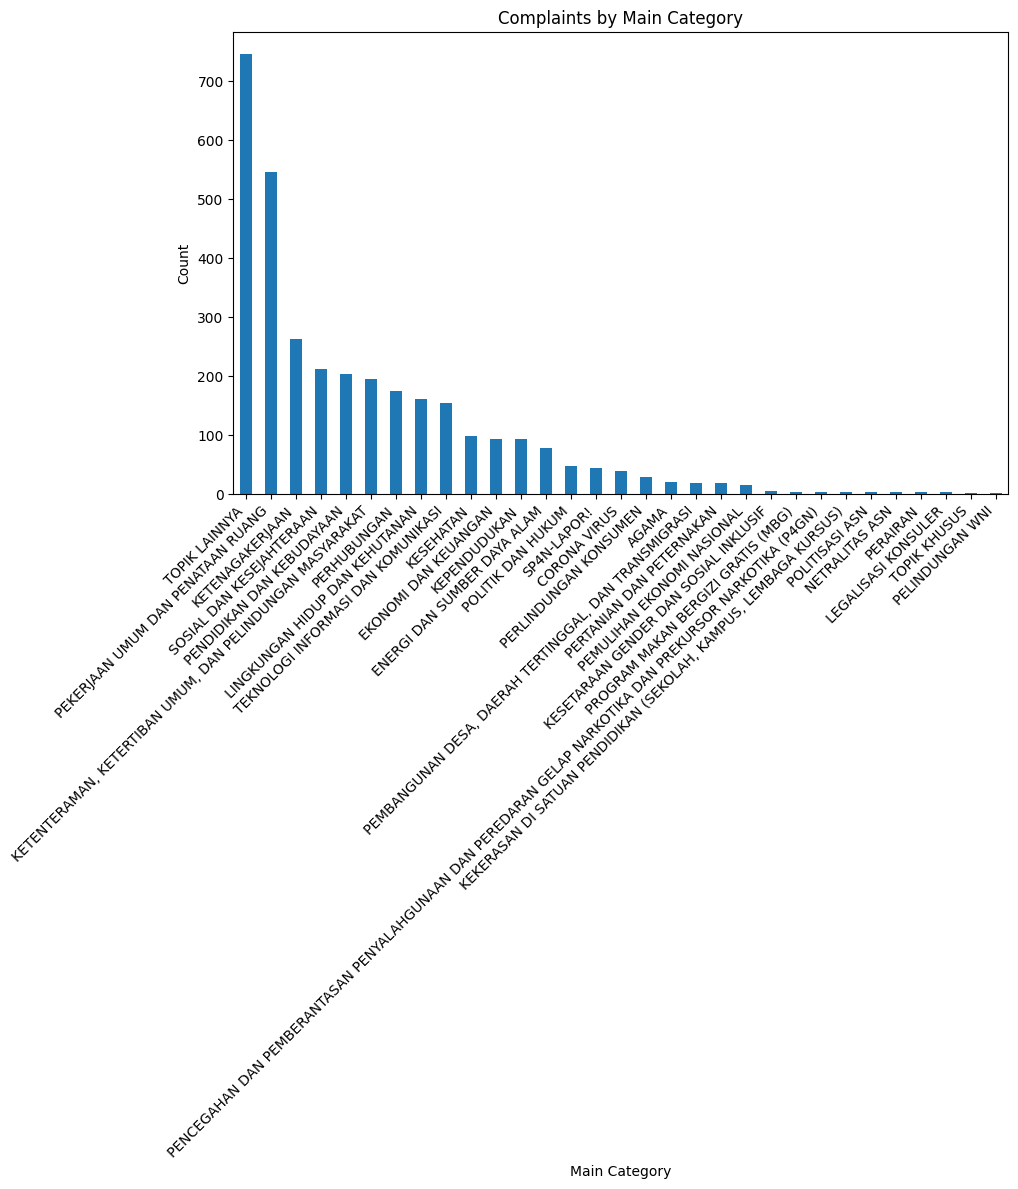

In [12]:
category_counts = categorized_df['main_category'].value_counts()

print("Counts by Main Category:")
print(category_counts)

print("\nPercentage Distribution:")
print(df['main_category'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

plt.figure(figsize=(10,6))
category_counts.plot(kind='bar')
plt.title('Complaints by Main Category')
plt.ylabel('Count')
plt.xlabel('Main Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()  
    return text.lower()

In [14]:
categorized_df['processed_text'] = categorized_df['complaint-title'] + " " + categorized_df['complaint-desc'] + " " + categorized_df['complaint-track-body']
categorized_df['processed_text'] = categorized_df['processed_text'].apply(preprocess_text)
print(f"{len(categorized_df):,} rows")

3,278 rows


In [15]:
def get_fasttext_embeddings(texts):
    ft = fasttext.load_model('/kaggle/working/cc.id.300.bin')
    embeddings = []
    for text in tqdm(texts, desc="FastText Progress", unit="text"):
        start_time = time.time()
        embedding = ft.get_sentence_vector(text)
        embeddings.append(embedding)
        time.sleep(0.01)  
    return np.array(embeddings)

def get_indobert_embeddings(texts):
    tokenizer = AutoTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')
    model = AutoModel.from_pretrained('cahya/bert-base-indonesian-522M')
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    embeddings = []
    for text in tqdm(texts, desc="IndoBERT Progress", unit="text"):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        embeddings.append(embedding)
    return np.array(embeddings)

def get_cendol_embeddings(texts):
    model = SentenceTransformer('indonlp/cendol-mt5-base-inst')
    return model.encode(texts, show_progress_bar=True, batch_size=8)

def get_e5_embeddings(texts):
    model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
    return model.encode(texts, show_progress_bar=True, batch_size=32)

def get_qwen3_embeddings(texts):
    tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-4B', padding_side='left')
    model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-4B').to('cuda')
    
    embeddings = []
    batch_size = 8  # Reduced for large model
    for i in tqdm(range(0, len(texts), batch_size), desc="Qwen3 Batches"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.extend(batch_embeddings)
    return np.array(embeddings)

In [16]:
texts = categorized_df['processed_text'].tolist()
categories = categorized_df['main_category'].tolist()

ros = RandomOverSampler(random_state=42)
texts_np = np.array(texts).reshape(-1, 1)  # Reshape for compatibility
texts_resampled, labels_resampled = ros.fit_resample(texts_np, categories)

texts_resampled = texts_resampled.ravel()

In [17]:
print(f"Before Oversampling: {Counter(categories)}")
print(f"After Oversampling:  {Counter(labels_resampled)}")

Before Oversampling: Counter({'TOPIK LAINNYA': 746, 'PEKERJAAN\xa0UMUM\xa0DAN\xa0PENATAAN\xa0RUANG': 546, 'KETENAGAKERJAAN': 262, 'SOSIAL\xa0DAN\xa0KESEJAHTERAAN': 212, 'PENDIDIKAN\xa0DAN\xa0KEBUDAYAAN': 203, 'KETENTERAMAN,\xa0KETERTIBAN\xa0UMUM,\xa0DAN\xa0PELINDUNGAN\xa0MASYARAKAT': 194, 'PERHUBUNGAN': 175, 'LINGKUNGAN\xa0HIDUP\xa0DAN\xa0KEHUTANAN': 161, 'TEKNOLOGI INFORMASI DAN KOMUNIKASI': 154, 'KESEHATAN': 98, 'EKONOMI\xa0DAN\xa0KEUANGAN': 93, 'KEPENDUDUKAN': 93, 'ENERGI DAN SUMBER DAYA ALAM': 77, 'POLITIK\xa0DAN\xa0HUKUM': 47, 'SP4N-LAPOR!': 44, 'CORONA VIRUS': 38, 'PERLINDUNGAN KONSUMEN': 28, 'AGAMA': 20, 'PERTANIAN\xa0DAN\xa0PETERNAKAN': 19, 'PEMBANGUNAN\xa0DESA,\xa0DAERAH\xa0TERTINGGAL,\xa0DAN\xa0TRANSMIGRASI': 19, 'PEMULIHAN EKONOMI NASIONAL': 15, 'KESETARAAN\xa0GENDER\xa0DAN\xa0SOSIAL\xa0INKLUSIF': 5, 'POLITISASI ASN': 4, 'PROGRAM MAKAN BERGIZI GRATIS (MBG)': 4, 'KEKERASAN DI SATUAN PENDIDIKAN (SEKOLAH, KAMPUS, LEMBAGA KURSUS)': 4, 'NETRALITAS ASN': 4, 'PENCEGAHAN DAN PEMBERA

In [15]:
embedding_files = {
    "Qwen3": "Qwen3_embeddings.npy",
    "FastText": "FastText_embeddings.npy",
    "IndoBERT": "IndoBERT_embeddings.npy",
    "CendolT5": "CendolT5_embeddings.npy",
    "MultilingualE5": "MultilingualE5_embeddings.npy"
}

results_summary = []
categories = categorized_df['main_category']

In [16]:
y = np.array(categories)

In [17]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def build_hybrid_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    conv = layers.Reshape((input_shape[0], 1))(inputs)
    conv = layers.Conv1D(256, 3, activation='swish')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling1D(2)(conv)
    conv = layers.Dropout(0.3)(conv)
    conv = layers.GlobalMaxPooling1D()(conv)
    
    lstm = layers.Reshape((input_shape[0], 1))(inputs)
    lstm = layers.LSTM(128, return_sequences=True)(lstm)
    lstm = layers.LSTM(64)(lstm)
    lstm = layers.Dropout(0.2)(lstm)
    
    dense = layers.Dense(512, activation='swish')(inputs)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.4)(dense)
    
    merged = layers.concatenate([conv, lstm, dense])
    x = layers.Dense(256, activation='swish')(merged)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score

results_summary = []

for name, file in embedding_files.items():
    print(f"\n==== Testing with {name} embeddings ====")
    
    X = np.load(f"/kaggle/input/embeddings/{file}")
    y = np.array(categories)

    class_counts = Counter(y)
    valid_classes = [cls for cls, count in class_counts.items() if count >= 10]
    filtered_indices = [i for i, label in enumerate(y) if label in valid_classes]
    X = X[filtered_indices]
    y = y[filtered_indices]

    unique_labels = np.unique(y)
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    y_encoded = np.array([label_to_index[label] for label in y])

    X_train, X_test, y_train_idx, y_test_idx = train_test_split(
        X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
    )

    y_train = tf.keras.utils.to_categorical(y_train_idx, num_classes=len(unique_labels))
    y_test = tf.keras.utils.to_categorical(y_test_idx, num_classes=len(unique_labels))

    class_weights_raw = compute_class_weight(class_weight='balanced', classes=np.arange(len(unique_labels)), y=y_train_idx)
    class_weights = {i: w for i, w in enumerate(class_weights_raw)}

    model = build_hybrid_model((X.shape[1],), num_classes=len(unique_labels))

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=64,
        class_weight=class_weights,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
        ],
        verbose=2
    )

    y_pred_probs = model.predict(X_test)
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    y_true_idx = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true_idx, y_pred_idx)
    f1 = f1_score(y_true_idx, y_pred_idx, average='macro')
    try:
        auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = np.nan  
    
    results_summary.append({
        "Embedding": name,
        "Accuracy": acc,
        "F1 (macro)": f1,
        "AUC": auc
    })


==== Testing with Qwen3 embeddings ====
Epoch 1/50
36/36 - 10s - 286ms/step - accuracy: 0.1485 - auc: 0.6414 - loss: 4.1237 - val_accuracy: 0.4189 - val_auc: 0.8474 - val_loss: 2.1373 - learning_rate: 3.0000e-04
Epoch 2/50
36/36 - 4s - 112ms/step - accuracy: 0.3947 - auc: 0.8512 - loss: 2.2059 - val_accuracy: 0.5390 - val_auc: 0.9112 - val_loss: 1.6939 - learning_rate: 3.0000e-04
Epoch 3/50
36/36 - 4s - 114ms/step - accuracy: 0.5273 - auc: 0.9068 - loss: 1.6275 - val_accuracy: 0.6047 - val_auc: 0.9304 - val_loss: 1.4900 - learning_rate: 3.0000e-04
Epoch 4/50
36/36 - 4s - 114ms/step - accuracy: 0.5780 - auc: 0.9308 - loss: 1.2948 - val_accuracy: 0.6160 - val_auc: 0.9425 - val_loss: 1.3663 - learning_rate: 3.0000e-04
Epoch 5/50
36/36 - 4s - 115ms/step - accuracy: 0.6436 - auc: 0.9496 - loss: 1.0321 - val_accuracy: 0.6448 - val_auc: 0.9461 - val_loss: 1.3237 - learning_rate: 3.0000e-04
Epoch 6/50
36/36 - 4s - 115ms/step - accuracy: 0.6894 - auc: 0.9601 - loss: 0.8596 - val_accuracy: 0.63

In [29]:
results_df = []
results_df = pd.DataFrame(results_summary)
print("\n=== Embedding Comparison ===")
print(results_df.sort_values("F1 (macro)", ascending=False).round(4))


=== Embedding Comparison ===
        Embedding  Accuracy  F1 (macro)     AUC
0           Qwen3    0.6899      0.5249  0.9317
4  MultilingualE5    0.7177      0.5048  0.9367
1        FastText    0.6530      0.4804  0.9320
2        IndoBERT    0.6016      0.4440  0.9006
3        CendolT5    0.5739      0.3860  0.8916


In [22]:
results = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {results[1]:.2%}")
print(f"Test AUC: {results[2]:.2%}")

model.save('complaint_classifier.h5')

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7374 - auc: 0.9684 - loss: 0.9624 - par: 0.6002

Test Accuracy: 72.79%
Test AUC: 96.55%
